## Global PFT Allometries  

We load Tallo and BAAD and then cross reference by species to pull in PFT information from BAAD for the Tallo species. 
This way we  can use the extra data in Tallo but make use of the deciduous v evergreen designations from BAAD. 
nb BAAD is included in Tallo so combining  them does not make sense. 

For AGB we use Chave 2014 parameters for tropical trees and fit to extra tropical PFTs using BAAD data. 

This work is a collaboration with Adrianna Foster and Marcos Longo. 

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo.csv')
df_env = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_tallo = pd.merge(df, df_env, on='tree_id', how='outer')

#### Make a PFT column that is so far just tropical/extra tropical and broad leaf evergreen

In [4]:
print(df_tallo['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
def condition(x) : 
    if x == 'Boreal/montane forest':
        return 'extratrop'
    elif x == 'Tropical rain forest': 
        return 'tropical'
    elif x == 'Temperate broadleaf forest': 
        return 'extratrop'
    elif x == 'Tropical savanna': 
        return 'tropical'
    elif x == 'Tropical dry forest': 
        return 'tropical'
    elif x == 'Temperate grassland': 
        return 'extratrop'
    elif x == 'Temperate conifer forest': 
        return 'extratrop'
    elif x == 'Mediterranean woodland': 
        return 'extratrop'
    elif x == 'Dryland': 
        return 'check'
    elif x == 'Mangrove': 
        return 'check'
    
df_tallo['pft1'] = df_tallo['biome'].apply(condition)

print(df_tallo['pft1'].unique())

['extratrop' 'tropical' 'check']


In [6]:
print(df_tallo['latitude'].min())
print(df_tallo['latitude'].max())

-51.56
69.88


In [7]:
# If biome isn't obvious use lat lon
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_tallo['pft1'] = df_tallo.apply(lambda row: condition1b(row['pft1'],  row['latitude']), axis=1)


In [8]:
print(df_tallo['pft1'].unique())

['extratrop' 'tropical']


In [9]:
def condition2(x) : 
    if x == 'Angiosperm':
        return 'broadleaf'
    elif x == 'Gymnosperm': 
        return 'needleleaf'
   
    
df_tallo['pft2'] = df_tallo['division'].apply(condition2)

print(df_tallo['pft2'].unique())
print(df_tallo['division'].unique())

['broadleaf' 'needleleaf' None]
['Angiosperm' 'Gymnosperm' nan]


In [10]:
df_tallo['PFT_tallo'] = df_tallo['pft2'] + '_' + df_tallo['pft1']

In [11]:
# only keep relevant columns
keep = ['species', 'latitude', 'longitude', 'stem_diameter_cm', 'height_m', 'height_outlier', 'crown_radius_m', 
       'crown_radius_outlier', 'PFT_tallo']

df_tallo = df_tallo[keep]

# make a crown area column
df_tallo['crown_area']  = np.pi * df_tallo['crown_radius_m']**2 
# rename them 
new_col_names = {'stem_diameter_cm': 'dbh', 'height_m': 'height'}
df_tallo.rename(columns=new_col_names, inplace=True)

print(df_tallo.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier             PFT_tallo  crown_area  
0            1.65                    N   broadleaf_extratrop    8.552986  
1            0.85                    N  needleleaf_extratrop    2.269801  
2            0.75                    N  needleleaf_extratrop    1.767146  


In [12]:
# Save the csv file 
df_tallo.to_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_PFTs.csv', index=False)


### Plot them  - by PFT

In [13]:
lon_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','longitude']
lat_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','latitude']

lon_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','longitude']
lat_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','latitude']

lon_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']

lon_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']


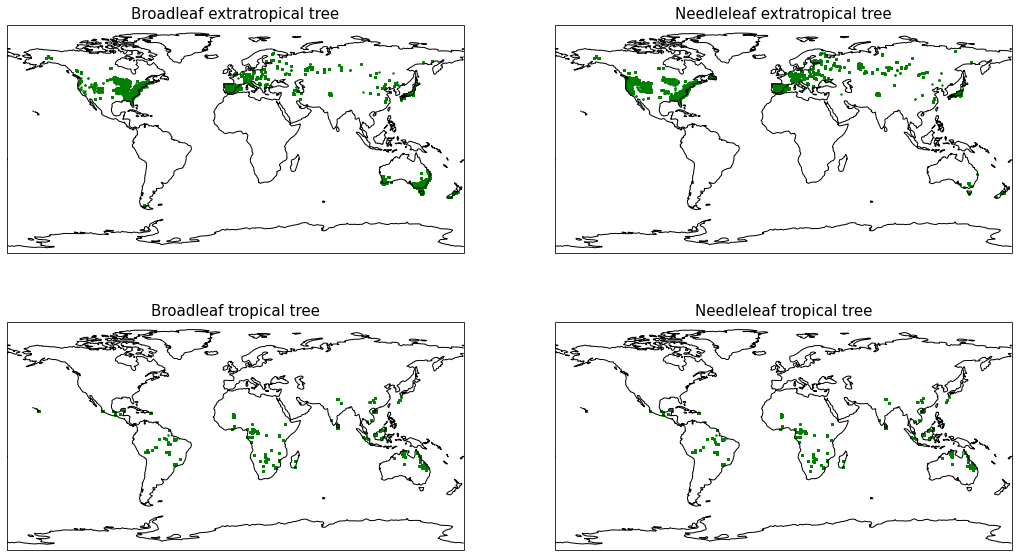

In [14]:
fig1, ((f1ax0,f1ax1),(f1ax2,f1ax3)) = plt.subplots(nrows=2,  ncols=2,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(18,10))
# Extra tropical broadleaf
f1ax0.scatter(lon_bl_ex, lat_bl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf extratropical tree', fontsize=15)

# Extra tropical needleleaf
f1ax1.scatter(lon_nl_ex, lat_nl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Needleleaf extratropical tree', fontsize=15)

# tropical broadleaf
f1ax2.scatter(lon_bl_tr, lat_bl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Broadleaf tropical tree', fontsize=15)

# tropical needleleaf
f1ax3.scatter(lon_nl_tr, lat_nl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()

### Load BAAD data and make a PFT column

Analysis adapted from Adrianna Foster

In [15]:
df_baad = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/baad_data_utf8.csv', encoding='utf-8')

In [16]:
def condition(x) : 
    if x == 'EA':
        return 'broadleaf_evergreen'
    elif x == 'EG': 
        return 'needleleaf_evergreen'
    elif x == 'DA': 
        return 'broadleaf_deciduous'
    elif x == 'DG': 
        return 'needleleaf_deciduous'
    
    
df_baad['pft_fates1'] = df_baad['pft'].apply(condition)

In [17]:
def condition(x) : 
    if x == 'Borf':
        return 'extratrop'
    elif x == 'TropRF': 
        return 'tropical'
    elif x == 'TempF': 
        return 'extratrop'
    elif x == 'Sh': 
        return 'check'
    elif x == 'TropSF': 
        return 'tropical'
    elif x == 'Wo': 
        return 'check'
    elif x == 'TempRF': 
        return 'extratrop'
    elif x == 'Sav': 
        return 'check'
    elif x == 'Gr': 
        return 'check'
    
df_baad['pft_fates2'] = df_baad['vegetation'].apply(condition)

In [18]:
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_baad['pft_fates2'] = df_baad.apply(lambda row: condition1b(row['pft_fates2'],  row['latitude']), axis=1)

In [19]:
# remove green house
allowed_growth = ['FW', 'FE', 'PU', 'PM']
mask = df_baad['growingCondition'].isin(allowed_growth)
df_baad = df_baad[mask]

In [20]:
df_baad['PFT_baad'] = df_baad['pft_fates1'] + '_' + df_baad['pft_fates2']

In [21]:
# remove nans in PFT
df_baad = df_baad.dropna(subset=['PFT_baad'])
print(df_baad['PFT_baad'].unique())

['broadleaf_evergreen_tropical' 'needleleaf_evergreen_extratrop'
 'broadleaf_evergreen_extratrop' 'broadleaf_deciduous_extratrop'
 'needleleaf_deciduous_extratrop' 'broadleaf_deciduous_tropical']


In [22]:
print(df_baad.columns)

Index(['studyName', 'latitude', 'longitude', 'vegetation', 'map', 'mat',
       'grouping', 'lai', 'species', 'speciesMatched', 'family', 'pft',
       'growingCondition', 'status', 'light', 'age', 'a.lf', 'a.ssba',
       'a.ssbh', 'a.ssbc', 'a.shba', 'a.shbh', 'a.shbc', 'a.sbba', 'a.sbbh',
       'a.sbbc', 'a.stba', 'a.stbh', 'a.stbc', 'a.cp', 'a.cs', 'h.t', 'h.c',
       'd.ba', 'd.bh', 'h.bh', 'd.cr', 'c.d', 'm.lf', 'm.ss', 'm.sh', 'm.sb',
       'm.st', 'm.so', 'm.br', 'm.rf', 'm.rc', 'm.rt', 'm.to', 'a.ilf',
       'ma.ilf', 'r.st', 'r.ss', 'r.sb', 'r.sh', 'n.lf', 'n.ss', 'n.sb',
       'n.sh', 'n.rf', 'n.rc', 'pft_fates1', 'pft_fates2', 'PFT_baad'],
      dtype='object')


In [23]:
# Select relevant columns
keep = ['PFT_baad', 'family',  'speciesMatched', 'latitude', 'longitude', 'd.bh', 'h.t', 'a.cp', 'm.so', 'r.st', 'm.lf']
df_baad = df_baad[keep]

# rename columns 
new_col_names = {'speciesMatched': 'species', 'd.bh': 'dbh', 'h.t': 'height', 'a.cp': 'crown_area',  'm.so': 'agb', 'r.st': 'wd', 'm.lf': 'bleaf'}
df_baad.rename(columns=new_col_names, inplace=True)

print(df_baad.head(3))

                        PFT_baad            family       species  latitude  \
17  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
18  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
19  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   

    longitude  dbh  height  crown_area      agb  wd    bleaf  
17     113.83  NaN    0.15      0.0449  0.00274 NaN  0.00206  
18     113.83  NaN    0.39      0.0570  0.00441 NaN  0.00187  
19     113.83  NaN    0.43      0.0471  0.00277 NaN  0.00132  


In [24]:
# keep only plants  with dbh
df_baad = df_baad.dropna(subset=['dbh'])
# convert dbh  to cm 
df_baad['dbh'] = df_baad['dbh'] * 100.0
#print(df_baad.head(3))

In [25]:
#print(df_baad.groupby(['PFT_baad']).count())

lon_bldex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_extratrop','longitude']
lat_bldex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_extratrop','latitude']

lon_bleex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_extratrop','longitude']
lat_bleex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_extratrop','latitude']

lon_nldex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_deciduous_extratrop','longitude']
lat_nldex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_deciduous_extratrop','latitude']

lon_nleex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_evergreen_extratrop','longitude']
lat_nleex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_evergreen_extratrop','latitude']

lon_bldtr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_tropical','longitude']
lat_bldtr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_tropical','latitude']

lon_bletr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_tropical','longitude']
lat_bletr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_tropical','latitude']


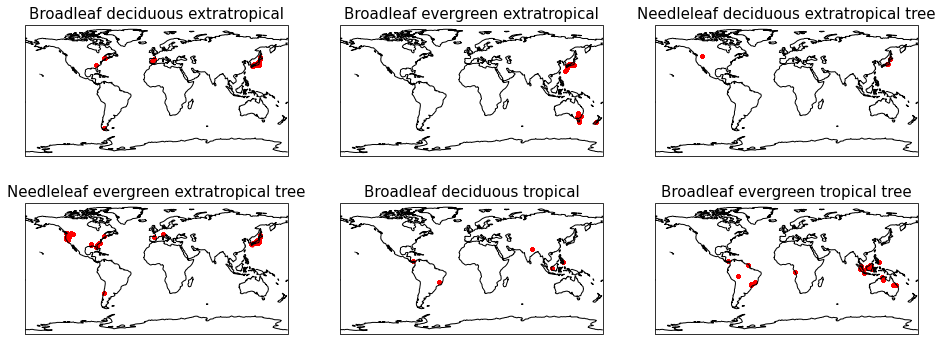

In [26]:
fig1, ((f1ax0,f1ax1,f1ax2),(f1ax3,f1ax4,f1ax5)) = plt.subplots(nrows=2,  ncols=3,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))
# Extra tropical deciduos broadleaf
f1ax0.scatter(lon_bldex, lat_bldex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf deciduous extratropical', fontsize=15)

# Extra tropical evergreen broadleaf
f1ax1.scatter(lon_bleex, lat_bleex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Broadleaf evergreen extratropical', fontsize=15)

# Extra tropical deciduous needleleaf
f1ax2.scatter(lon_nldex, lat_nldex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Needleleaf deciduous extratropical tree', fontsize=15)

# Extra tropical evergreen needleleaf
f1ax3.scatter(lon_nleex, lat_nleex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf evergreen extratropical tree', fontsize=15)

# tropical deciduous broadleaf
f1ax4.scatter(lon_bldtr, lat_bldtr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax4.coastlines()
f1ax4.set_title('Broadleaf deciduous tropical', fontsize=15)

# tropical evergreen broadleaf 
f1ax5.scatter(lon_bletr, lat_bletr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax5.coastlines()
f1ax5.set_title('Broadleaf evergreen tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()
f1ax4.set_global()
f1ax5.set_global()



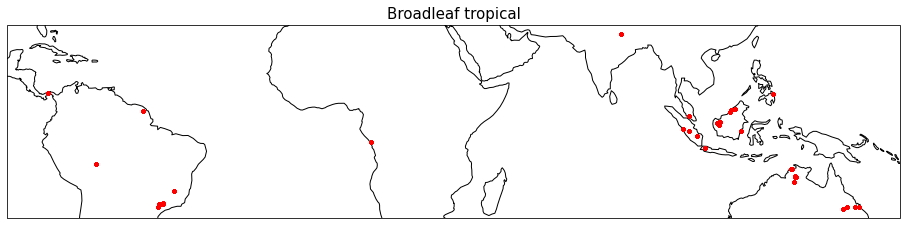

In [27]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,  ncols=1,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))
# tropical deciduous broadleaf
f1ax0.scatter(lon_bldtr, lat_bldtr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf tropical', fontsize=15)

# tropical evergreen broadleaf 
f1ax0.scatter(lon_bletr, lat_bletr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())

#f1ax0.set_global()


### Use  PFT info from BAAD for Tallo data 

In [28]:
# make a table of unique species and pfts from BAAD
baad_pfts = df_baad[['species', 'PFT_baad']]
baad_pfts = baad_pfts.drop_duplicates()
baad_pfts.head(3)

print(baad_pfts.groupby('PFT_baad')['species'].count())

PFT_baad
broadleaf_deciduous_extratrop      97
broadleaf_deciduous_tropical       21
broadleaf_evergreen_extratrop      54
broadleaf_evergreen_tropical      187
needleleaf_deciduous_extratrop      3
needleleaf_evergreen_extratrop     30
Name: species, dtype: int64


In [29]:
merged_df = df_tallo.merge(baad_pfts, left_on='species', right_on='species', how='left')
merged_df['PFT_tallo'] = merged_df['PFT_baad'].fillna(merged_df['PFT_tallo'])
merged_df = merged_df.drop(columns=['PFT_baad'])
print(merged_df.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier                       PFT_tallo  \
0            1.65                    N             broadleaf_extratrop   
1            0.85                    N  needleleaf_evergreen_extratrop   
2            0.75                    N  needleleaf_evergreen_extratrop   

   crown_area  
0    8.552986  
1    2.269801  
2    1.767146  


In [30]:
print(merged_df['PFT_tallo'].unique())

['broadleaf_extratrop' 'needleleaf_evergreen_extratrop'
 'broadleaf_evergreen_extratrop' 'broadleaf_tropical'
 'broadleaf_evergreen_tropical' 'needleleaf_tropical'
 'broadleaf_deciduous_extratrop' 'broadleaf_deciduous_tropical' nan
 'needleleaf_extratrop' 'needleleaf_deciduous_extratrop']


In [31]:
# replace all broadleaf deciduous/evergreen with just broadleaf tropical 
def condition(x) : 
    if x == 'broadleaf_evergreen_tropical':
        return 'broadleaf_tropical'
    elif x == 'broadleaf_deciduous_tropical': 
        return 'broadleaf_tropical'
    else : 
        return x
    
merged_df['PFT_tallo'] = merged_df['PFT_tallo'].apply(condition)

print(merged_df.groupby('PFT_tallo')['species'].count())

PFT_tallo
broadleaf_deciduous_extratrop      33829
broadleaf_evergreen_extratrop       8275
broadleaf_extratrop               118968
broadleaf_tropical                174223
needleleaf_deciduous_extratrop       224
needleleaf_evergreen_extratrop     38192
needleleaf_extratrop               62645
needleleaf_tropical                 1921
Name: species, dtype: int64


In [32]:
df_tallo = merged_df

In [33]:
### Save them 
df_tallo.to_csv('/pscratch/sd/j/jneedham/trait_data/df_tallo.csv', index=False)
df_baad.to_csv('/pscratch/sd/j/jneedham/trait_data/df_baad.csv', index=False)

#### Also replace BAAD tropical pfts with single pft  - for AGB analysis

In [34]:
df_baad['PFT_baad'] = df_baad['PFT_baad'].apply(condition)

print(df_baad.groupby('PFT_baad')['species'].count())

PFT_baad
broadleaf_deciduous_extratrop     1270
broadleaf_evergreen_extratrop     1270
broadleaf_tropical                2898
needleleaf_deciduous_extratrop      83
needleleaf_evergreen_extratrop    1805
Name: species, dtype: int64


## Sample sizes - total number of observations
For height and crown area : 

In [35]:
x = df_tallo.groupby(['PFT_tallo']).count()
print(x[['height','crown_area']])

                                height  crown_area
PFT_tallo                                         
broadleaf_deciduous_extratrop    33290       22847
broadleaf_evergreen_extratrop     8275        4518
broadleaf_extratrop             118885       82676
broadleaf_tropical              173776      102140
needleleaf_deciduous_extratrop     224         154
needleleaf_evergreen_extratrop   37900       31066
needleleaf_extratrop             62856       45753
needleleaf_tropical               1919         821


For AGB :  

In [36]:
x = df_baad.groupby(['PFT_baad']).count()
print(x['agb'])


PFT_baad
broadleaf_deciduous_extratrop     1168
broadleaf_evergreen_extratrop     1175
broadleaf_tropical                1713
needleleaf_deciduous_extratrop      69
needleleaf_evergreen_extratrop     992
Name: agb, dtype: int64


## Sample sizes - by species 
For height and  crown area : 

In [37]:
df_tallo.groupby('PFT_tallo')['species'].nunique().reset_index(name='N_species')

,PFT_tallo,N_species
0,broadleaf_deciduous_extratrop,84
1,broadleaf_evergreen_extratrop,48
2,broadleaf_extratrop,739
3,broadleaf_tropical,4233
4,needleleaf_deciduous_extratrop,3
5,needleleaf_evergreen_extratrop,30
6,needleleaf_extratrop,86
7,needleleaf_tropical,31


For AGB :

In [38]:
df_baad.groupby('PFT_baad')['species'].nunique().reset_index(name='N_species')

,PFT_baad,N_species
0,broadleaf_deciduous_extratrop,97
1,broadleaf_evergreen_extratrop,54
2,broadleaf_tropical,207
3,needleleaf_deciduous_extratrop,3
4,needleleaf_evergreen_extratrop,30


## Martinez-cano height allometry

In [39]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


#### Broadleaf tropical

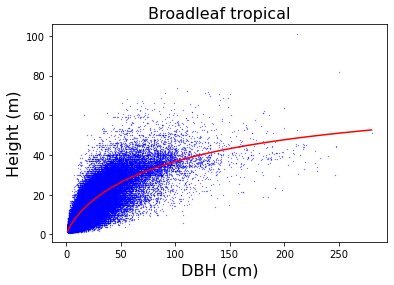

In [40]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
bltr =  bltr.dropna(subset=['height', 'dbh'])
# remove outliers
bltr = bltr[bltr['height_outlier'] == 'N']
dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

height_ps_bltr, height_cov_bltr = curve_fit(f=d2hmc, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['height']),
                                           p0=initial_guess)
bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh_bltr]

#plt.scatter(bltr.dbh, bltr.height, s=0.01, c=pd.factorize(bltr['species'])[0])
plt.scatter(bltr.dbh, bltr.height, s=0.05, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)',  fontsize=16)
plt.ylabel('Height (m)',  fontsize=16)
plt.title('Broadleaf tropical',  fontsize=16)

#print(height_ps_bltr)

bltr_dbh_h = bltr.dbh
bltr_height = bltr.height
bltr_curve_height = bltr_curve

#### Needleleaf evergreen extra tropical  

[306.84266695   0.75237703 196.68656908]


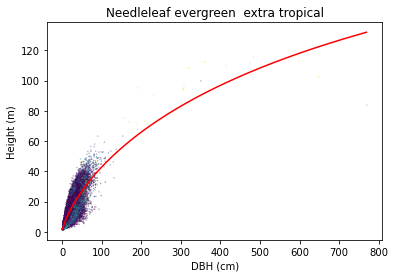

In [41]:
# Needleleaf evergreen extra tropical 
nleex = df_tallo[df_tallo.PFT_tallo=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['height', 'dbh'])
# remove outliers
nleex = nleex[nleex['height_outlier'] == 'N']

height_ps_nleex, height_cov_nleex = curve_fit(f=d2hmc, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['height']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.height, s=0.05, c=pd.factorize(nleex['species'])[0])
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf evergreen  extra tropical')

print(height_ps_nleex)

#### Needleleaf deciduous extra tropical 

[106.87458211   0.94713018  93.97904614]


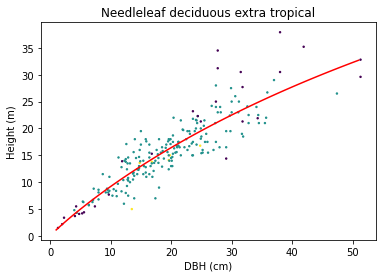

In [42]:
# Needleleaf deciduous extra tropical 
nldex = df_tallo[df_tallo.PFT_tallo=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['height', 'dbh'])
# remove outliers
nldex = nldex[nldex['height_outlier'] == 'N']

height_ps_nldex, height_cov_nldex = curve_fit(f=d2hmc, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['height']),
                                           p0=initial_guess)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.height, s=2, c=pd.factorize(nldex['species'])[0])
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf deciduous extra tropical')

print(height_ps_nldex)

#### Broadleaf evergreen extra tropical  

[104.3586841    1.11469727 160.68350891]


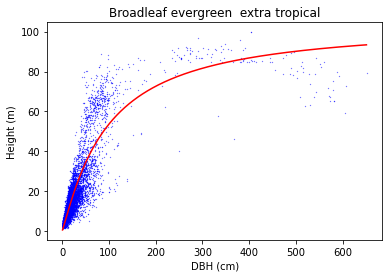

In [43]:
# Broadleaf evergreen extra tropical 
bleex = df_tallo[df_tallo.PFT_tallo=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['height', 'dbh'])
# remove outliers
bleex = bleex[bleex['height_outlier'] == 'N']

height_ps_bleex, height_cov_bleex = curve_fit(f=d2hmc, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['height']),
                                           p0=initial_guess)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.height, s=0.05, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf evergreen  extra tropical')

print(height_ps_bleex)

#### Broadleaf deciduous extra tropical 

[29.69929379  1.12959569 25.12579143]


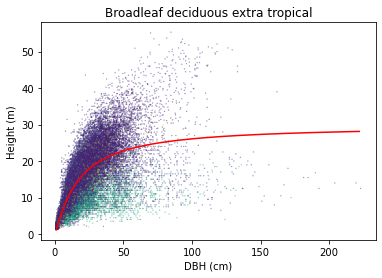

In [44]:
# Broadleaf deciduous extra tropical 
bldex = df_tallo[df_tallo.PFT_tallo=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['height', 'dbh'])
# remove outliers
bldex = bldex[bldex['height_outlier'] == 'N']

height_ps_bldex, height_cov_bldex = curve_fit(f=d2hmc, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['height']),
                                           p0=initial_guess)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.height, s=0.05, c=pd.factorize(bldex['species'])[0])
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf deciduous extra tropical')

print(height_ps_bldex)

What is going on with those tall and short trees? 

In [45]:
value_counts = bldex['species'].value_counts()
print(value_counts)

Fagus sylvatica       8931
Acer saccharum        5743
Quercus pyrenaica     4129
Acer rubrum           3540
Fagus grandifolia     1749
                      ... 
Aesculus turbinata       1
Alnus pendula            1
Mallotus japonicus       1
Magnolia kobus           1
Acer japonicum           1
Name: species, Length: 84, dtype: int64


Text(0.5, 0.01, 'DBH (cm)')

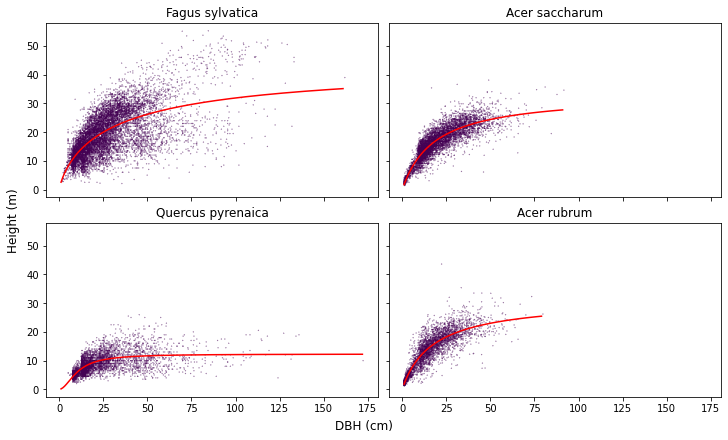

In [46]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        figsize=(10,6), sharex=True,  sharey=True, constrained_layout=True)

axs=axs.flatten()

species = ['Fagus sylvatica', 'Acer saccharum',  'Quercus pyrenaica', 'Acer rubrum']

for i  in range(0,len(species))  :
    
    bldex = df_tallo[df_tallo.species==species[i]]
    bldex =  bldex.dropna(subset=['height', 'dbh'])
    # remove outliers
    bldex = bldex[bldex['height_outlier'] == 'N']

    height_ps_bldex, height_cov_bldex = curve_fit(f=d2hmc, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['height']),
                                               p0=initial_guess)
    
    dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

    bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh_bldex]
    axs[i].scatter(bldex.dbh, bldex.height, s=0.05, c=pd.factorize(bldex['species'])[0])
    axs[i].plot(dbh_bldex, bldex_curve, color='red')
    axs[i].set_title(species[i])

fig.supylabel('Height (m)')
fig.supxlabel('DBH (cm)')

#### Plot all of them - note the different x and y axes

''

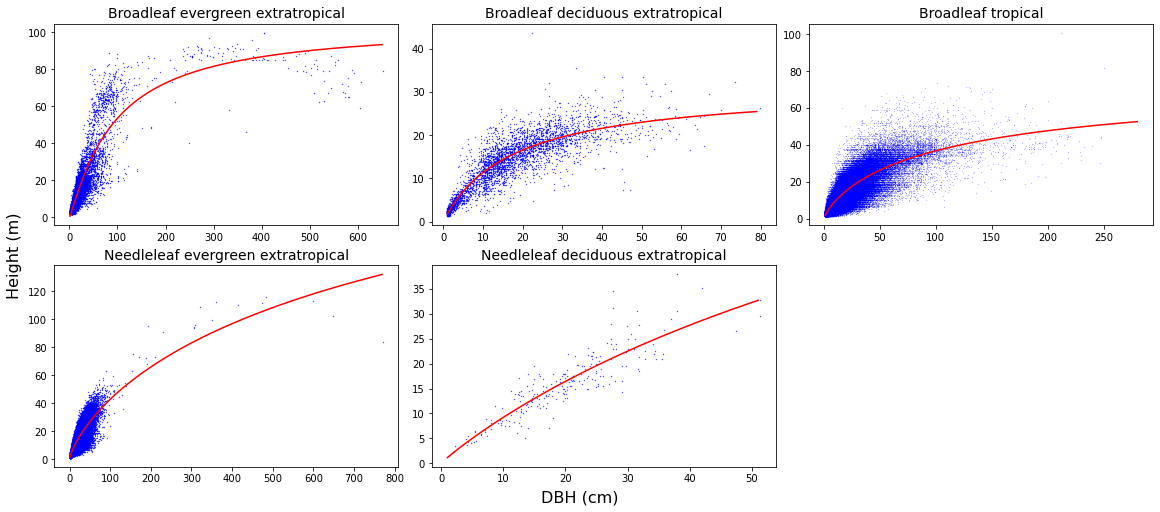

In [47]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.height, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.height, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.height, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.height, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.height, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Height (m)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [48]:
dbh = np.arange(1,350,1)
bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh]
nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh]
bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh]
nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh]
bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh]


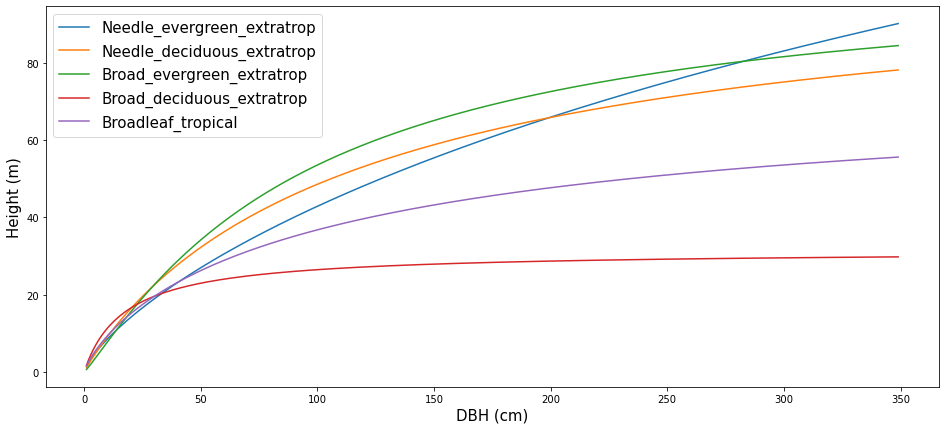

In [49]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf_tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('Height (m)',  fontsize=15)
f2ax0.legend(fontsize=15)

### Crown area allometry

In [50]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

[0.27158909 1.48196794]


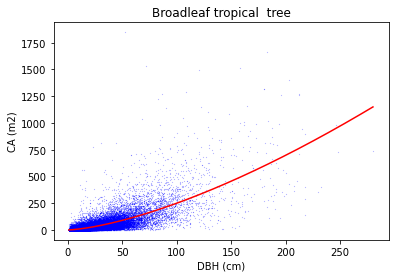

In [51]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
# remove outliers
bltr = bltr[bltr['crown_radius_outlier'] == 'N']
bltr =  bltr.dropna(subset=['crown_area', 'dbh'])
dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

ca_ps_bltr, ca_cov_bltr = curve_fit(f=d2ca, xdata=np.array(bltr['dbh']),
                                    ydata=np.array(bltr['crown_area']), p0=[0.7,1.3])

bltr_curve = [d2ca(d, ca_ps_bltr[0], ca_ps_bltr[1])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m2)')
plt.title('Broadleaf tropical  tree')

print(ca_ps_bltr)

bltr_dbh_ca = bltr.dbh
bltr_ca = bltr.crown_area
bltr_curve_ca = bltr_curve

[0.36937181 1.18343727]


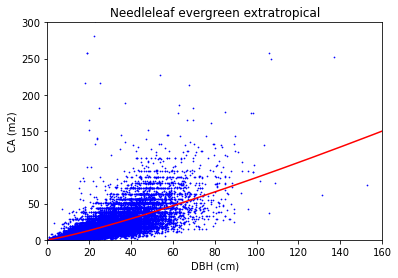

In [52]:
# Needleleaf  evergreen extra tropical
nleex = df_tallo[df_tallo.PFT_tallo=='needleleaf_evergreen_extratrop']
# remove outliers
nleex = nleex[nleex['crown_radius_outlier'] == 'N']
nleex =  nleex.dropna(subset=['crown_area', 'dbh'])
dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

ca_ps_nleex, ca_cov_nleex = curve_fit(f=d2ca, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['crown_area']), p0=[0.7,1.3])

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)
nleex_curve = [d2ca(d, ca_ps_nleex[0], ca_ps_nleex[1])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.crown_area, s=0.5, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m2)')
plt.title('Needleleaf evergreen extratropical')
plt.xlim(0,160)
plt.ylim(0,300)

print(ca_ps_nleex)

[1.07872587 0.98512371]


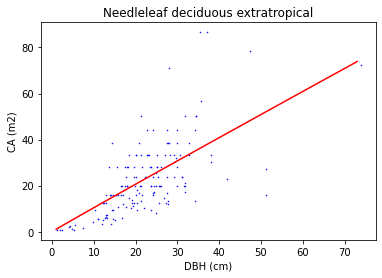

In [53]:
# Needleleaf  deciduous extra tropical
nldex = df_tallo[df_tallo.PFT_tallo =='needleleaf_deciduous_extratrop']
# remove outliers
nldex = nldex[nldex['crown_radius_outlier'] == 'N']
nldex =  nldex.dropna(subset=['crown_area', 'dbh'])
dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

ca_ps_nldex, ca_cov_nldex = curve_fit(f=d2ca, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['crown_area']), p0=[0.7,1.3])

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)
nldex_curve = [d2ca(d, ca_ps_nldex[0], ca_ps_nldex[1])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m2)')
plt.title('Needleleaf deciduous extratropical')

print(ca_ps_nldex)

[0.05792968 1.74213967]


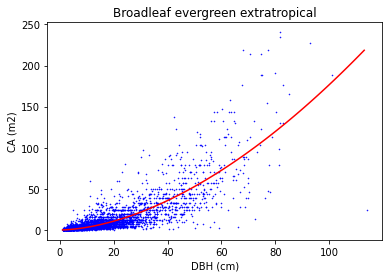

In [54]:
# broadleaf  evergreen extra tropical
bleex = df_tallo[df_tallo.PFT_tallo =='broadleaf_evergreen_extratrop']
# remove outliers
bleex = bleex[bleex['crown_radius_outlier'] == 'N']
bleex =  bleex.dropna(subset=['crown_area', 'dbh'])
dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

ca_ps_bleex, ca_cov_bleex = curve_fit(f=d2ca, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['crown_area']), p0=[0.7,1.3])

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)
bleex_curve = [d2ca(d, ca_ps_bleex[0], ca_ps_bleex[1])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m2)')
plt.title('Broadleaf evergreen extratropical')

print(ca_ps_bleex)

[1.15536123 1.04989388]


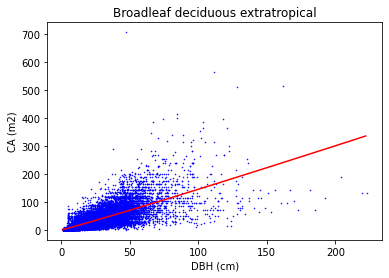

In [55]:
# broadleaf deciduous extra tropical
bldex = df_tallo[df_tallo.PFT_tallo =='broadleaf_deciduous_extratrop']
# remove outliers
bldex = bldex[bldex['crown_radius_outlier'] == 'N']
bldex =  bldex.dropna(subset=['crown_area', 'dbh'])
dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

ca_ps_bldex, ca_cov_bldex = curve_fit(f=d2ca, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['crown_area']), p0=[0.7,1.3])

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)
bldex_curve = [d2ca(d, ca_ps_bldex[0], ca_ps_bldex[1])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m2)')
plt.title('Broadleaf deciduous extratropical')

print(ca_ps_bldex)

''

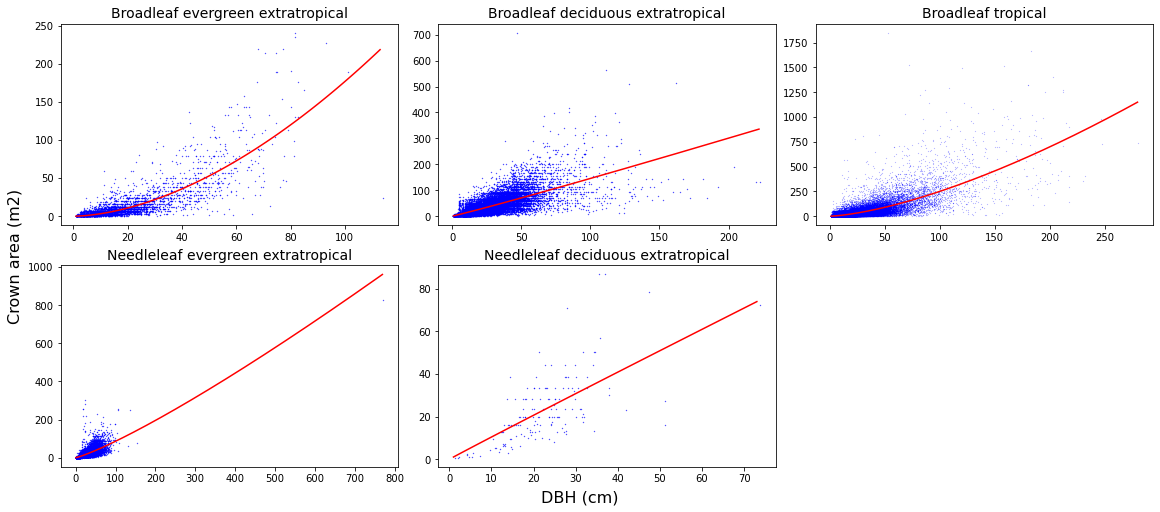

In [56]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.crown_area, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.crown_area, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.crown_area, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.crown_area, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Crown area (m2)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [57]:
dbh = np.arange(1,350,1)
bldex_curve = [d2ca(d, ca_ps_bldex[0], ca_ps_bldex[1])  for  d  in dbh]
nldex_curve = [d2ca(d, ca_ps_nldex[0], ca_ps_nldex[1])  for  d  in dbh]
bleex_curve = [d2ca(d, ca_ps_bleex[0], ca_ps_bleex[1])  for  d  in dbh]
nleex_curve = [d2ca(d, ca_ps_nleex[0], ca_ps_nleex[1])  for  d  in dbh]
bltr_curve = [d2ca(d, ca_ps_bltr[0], ca_ps_bltr[1])  for  d  in dbh]


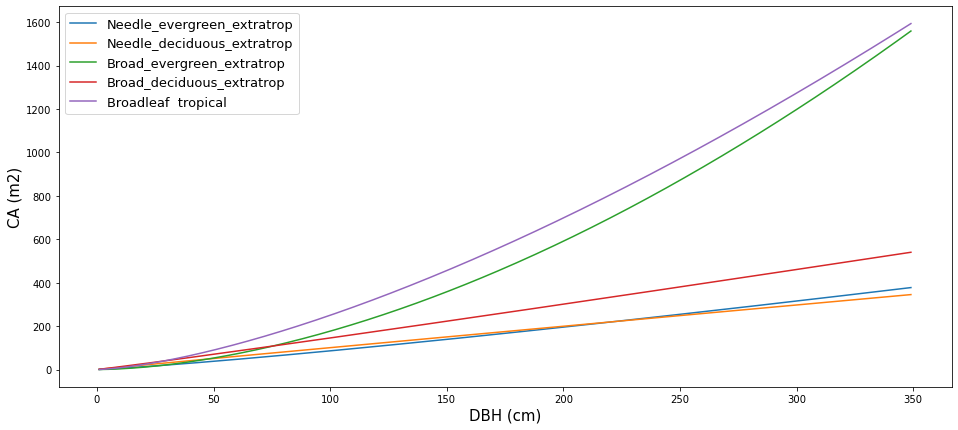

In [58]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf  tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('CA (m2)',  fontsize=15)
f2ax0.legend(fontsize=13)

## Aboveground biomass

We will only do  this for extra tropical since the tropical PFTs can use Chave 2014 parameters.
We will likely need to read in wood density estimates for many species that are lacking data in BAAD.

#### Load Wood Density Data 
These data are from TRY - compiled by Marcos Longo

In [59]:
df_wd = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/wood_density_utf8.csv')

# remove the outlier
max_index = df_wd['wood_dens'].idxmax()
print(df_wd.loc[max_index])

df_wd = df_wd[df_wd['wood_dens'] < 20.0]

ScientificName    Cecropia glaziovii
wood_dens                      22.15
Name: 49328, dtype: object


##### Make a new look up table with mean value per species

In [60]:
df_wd_mean = df_wd.groupby('ScientificName')['wood_dens'].mean().reset_index()
print(df_wd_mean.head(4))

            ScientificName  wood_dens
0  ARCTOSTAPHYLOS UVA-URSI   0.515767
1       Abarema adenophora   0.511729
2      Abarema barbouriana   0.418682
3    Abarema brachystachya   0.537852


In [61]:
print(df_wd_mean['wood_dens'].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.999, 1.0]))

max_index = df_wd_mean['wood_dens'].idxmax()
print(df_wd_mean.loc[max_index])

0.250    0.477984
0.500    0.595008
0.750    0.715000
0.950    0.890000
0.990    1.010000
0.995    1.092233
0.999    1.476936
1.000    5.191211
Name: wood_dens, dtype: float64
ScientificName    Bathysa australis
wood_dens                  5.191211
Name: 1192, dtype: object


In [62]:
# fill in bad data with wood density from TRY (from Marcos Longo)
print(df_baad['wd'].count())

1140


In [63]:
# Merge DataFrames based on matching values in 'x' and 's'
merged_df = df_baad.merge(df_wd_mean, left_on='species', right_on='ScientificName', how='left')
merged_df['wd'] = merged_df['wood_dens'].fillna(merged_df['wd'])
merged_df = merged_df.drop(columns=['wood_dens'])

In [64]:
print(merged_df['wd'].count())
df_baad = merged_df

5671


In [65]:
# Set outlier wd to NA
max_index = df_baad['wd'].idxmax()
#print(df_baad.loc[max_index])
#print(df_baad['wd'].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.999, 1.0]))

# replace all broadleaf deciduous/evergreen with just broadleaf tropical 
def condition(x) : 
    if x > 100 :
        return np.nan
    else : 
        return x
    
df_baad['wd'] = df_baad['wd'].apply(condition)

print(df_baad['wd'].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 1.0]))


0.25    0.438479
0.50    0.513000
0.75    0.651493
0.95    0.846058
0.99    0.967907
1.00    1.026544
Name: wd, dtype: float64


In [66]:
# Let's actually use mean wd by PFT  for fitting curves
pft_wd_means = df_baad.groupby('PFT_baad')['wd'].mean().reset_index()
print(pft_wd_means)

                         PFT_baad        wd
0   broadleaf_deciduous_extratrop  0.566452
1   broadleaf_evergreen_extratrop  0.754336
2              broadleaf_tropical  0.548327
3  needleleaf_deciduous_extratrop  0.454845
4  needleleaf_evergreen_extratrop  0.442350


#### Needleleaf evergreen extra tropical 

[0.13640117 0.94490413]


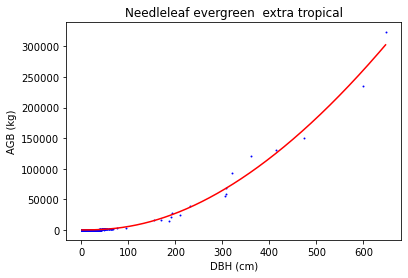

In [67]:
# Needleleaf evergreen extra tropical 
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['agb', 'dbh'])
dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_nleex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'needleleaf_evergreen_extratrop', 'wd'].values[0]
    h1 = height_ps_nleex[0]
    h2 = height_ps_nleex[1]
    h3 = height_ps_nleex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nleex, agb_cov_nleex = curve_fit(f=dh2bagw_nleex, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['agb']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [dh2bagw_nleex(d, agb_ps_nleex[0], agb_ps_nleex[1])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.agb, s=0.9, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Needleleaf evergreen  extra tropical')

print(agb_ps_nleex)

#### Needleleaf deciduous extra tropical 

[0.03930566 1.08733502]


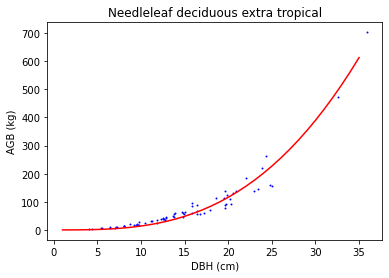

In [68]:
# Needleleaf deciduous extra tropical 
nldex = df_baad[df_baad.PFT_baad=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['agb', 'dbh'])
dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_nldex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'needleleaf_deciduous_extratrop', 'wd'].values[0]
    h1 = height_ps_nldex[0]
    h2 = height_ps_nldex[1]
    h3 = height_ps_nldex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nldex, agb_cov_nldex = curve_fit(f=dh2bagw_nldex, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['agb']),
                                           p0=initial_guess)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

nldex_curve = [dh2bagw_nldex(d, agb_ps_nldex[0], agb_ps_nldex[1])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.agb, s=0.9, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Needleleaf deciduous extra tropical')

print(agb_ps_nldex)

#### Broadleaf evergreen extra tropical 

[0.26536947 0.83213205]


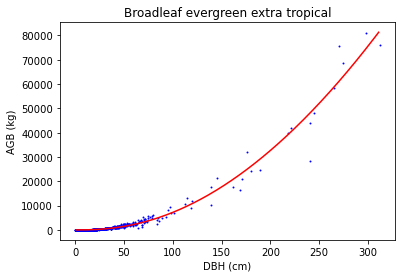

In [69]:
# Broadleaf evergreen extra tropical 
bleex = df_baad[df_baad.PFT_baad=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['agb', 'dbh'])
dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_bleex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'broadleaf_evergreen_extratrop', 'wd'].values[0]
    h1 = height_ps_bleex[0]
    h2 = height_ps_bleex[1]
    h3 = height_ps_bleex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_bleex, agb_cov_bleex = curve_fit(f=dh2bagw_bleex, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['agb']),
                                           p0=initial_guess)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

bleex_curve = [dh2bagw_bleex(d, agb_ps_bleex[0], agb_ps_bleex[1])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.agb, s=0.9, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf evergreen extra tropical')

print(agb_ps_bleex)

#### Broadleaf deciduous extra tropical

[0.07286975 1.03732112]


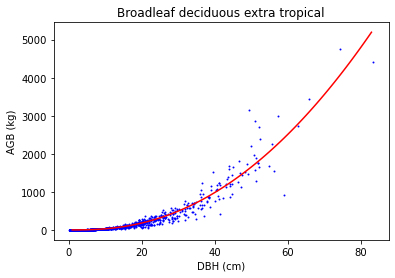

In [70]:
# Broadleaf deciduous extra tropical 
bldex = df_baad[df_baad.PFT_baad=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['agb', 'dbh'])
dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_bldex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'broadleaf_deciduous_extratrop', 'wd'].values[0]
    h1 = height_ps_bldex[0]
    h2 = height_ps_bldex[1]
    h3 = height_ps_bldex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_bldex, agb_cov_bldex = curve_fit(f=dh2bagw_bldex, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['agb']),
                                           p0=initial_guess)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

bldex_curve = [dh2bagw_bldex(d, agb_ps_bldex[0], agb_ps_bldex[1])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.agb, s=0.9, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf deciduous extra tropical')

print(agb_ps_bldex)

#### Broadleaf tropical

[0.09419326 1.0322091 ]


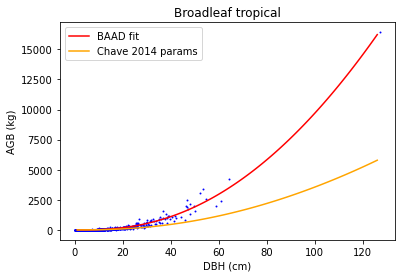

In [71]:
# Broadleaf deciduous extra tropical 
bltr = df_baad[df_baad.PFT_baad=='broadleaf_tropical']
bltr =  bltr.dropna(subset=['agb', 'dbh'])
dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_bltr (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'broadleaf_tropical', 'wd'].values[0]
    h1 = height_ps_bltr[0]
    h2 = height_ps_bltr[1]
    h3 = height_ps_bltr[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_bltr, agb_cov_bltr = curve_fit(f=dh2bagw_bltr, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['agb']),
                                           p0=initial_guess)

bltr_curve = [dh2bagw_bltr(d, agb_ps_bltr[0], agb_ps_bltr[1])  for  d  in dbh_bltr]

chave_ps = [0.0673, 0.976]

bltr_curve_chave = [dh2bagw_bltr(d, chave_ps[0], chave_ps[1])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.agb, s=0.9, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red', label = 'BAAD fit')
plt.plot(dbh_bltr, bltr_curve_chave, color='orange', label = 'Chave 2014 params')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf tropical')
plt.legend()

print(agb_ps_bltr)

bltr_dbh_agb = bltr.dbh
bltr_agb = bltr.agb

''

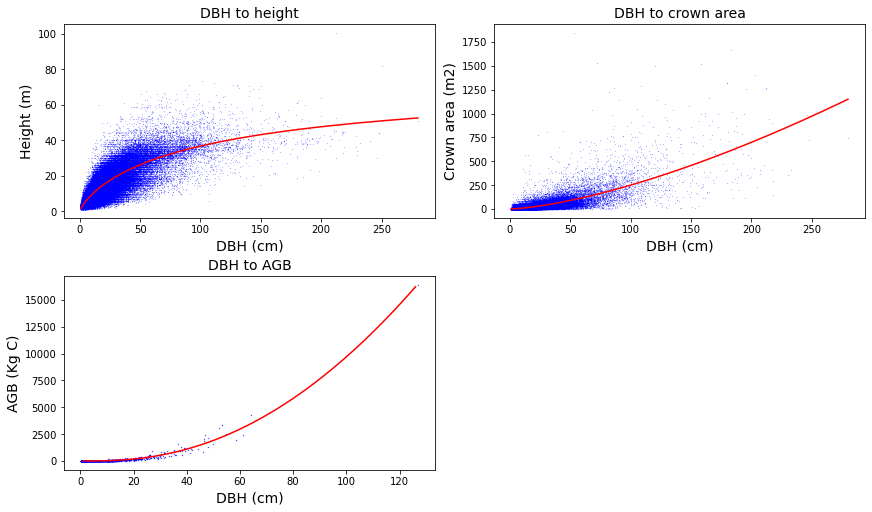

In [72]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3)) = plt.subplots(nrows=2,ncols=2,
                        figsize=(12,7), constrained_layout=True)

dbh_bltr_h = np.arange(1,max(bltr_dbh_h),1)
f2ax0.scatter(bltr_dbh_h, bltr_height, s=0.01, color='blue')
f2ax0.plot(dbh_bltr_h, bltr_curve_height, color='red')
f2ax0.set_title('DBH to height', fontsize=14)
f2ax0.set_xlabel('DBH (cm)',  fontsize=14)
f2ax0.set_ylabel('Height (m)',  fontsize=14)

dbh_bltr_ca = np.arange(1,max(bltr_dbh_ca),1)
f2ax1.scatter(bltr_dbh_ca, bltr_ca, s=0.01, color='blue')
f2ax1.plot(dbh_bltr_ca, bltr_curve_ca, color='red')
f2ax1.set_title('DBH to crown area', fontsize=14)
f2ax1.set_xlabel('DBH (cm)',  fontsize=14)
f2ax1.set_ylabel('Crown area (m2)',  fontsize=14)


f2ax2.scatter(bltr_dbh_agb, bltr_agb, s=0.1, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('DBH to AGB', fontsize=14)
f2ax2.set_xlabel('DBH (cm)',  fontsize=14)
f2ax2.set_ylabel('AGB (Kg C)',  fontsize=14)


f2ax3.axis('off')

;

''

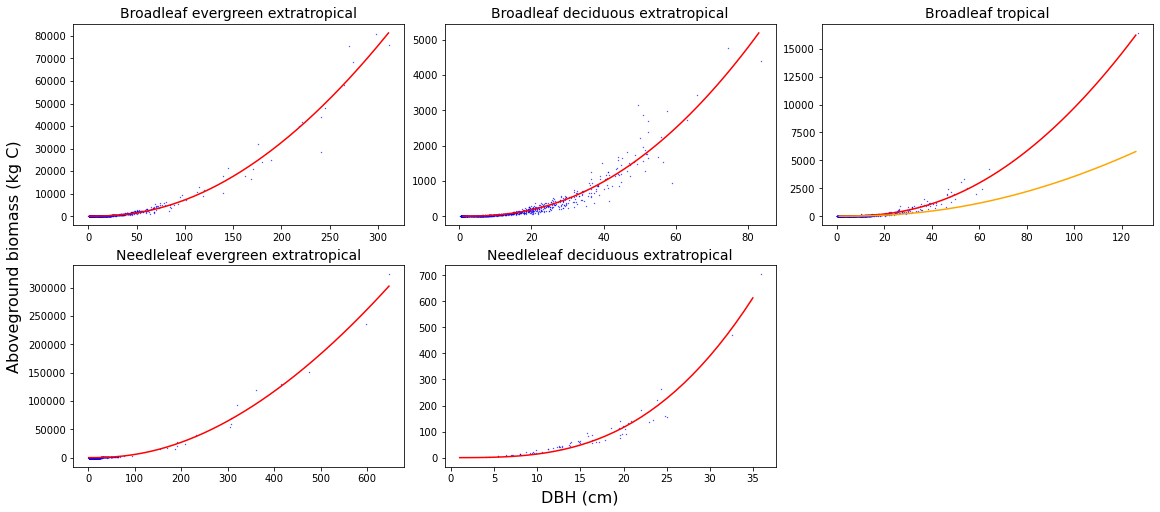

In [73]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.agb, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.agb, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.agb, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.agb, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.agb, s=0.1, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.plot(dbh_bltr, bltr_curve_chave, color='orange')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Aboveground biomass (kg C)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

####  Baad  v Chave et al.  2014

BAAD has 207 tropical  speccies and 1713 observations. 
Chave has 4004 observations from 58 sites. We  will use Chave et al.  parameters moving forward.  

## Final values

In [74]:
fates_allom_d2ca_coefficient_max = [ca_ps_bltr[0], ca_ps_nleex[0], ca_ps_nldex[0], ca_ps_bleex[0], ca_ps_bltr[0], ca_ps_bldex[0]]
#print(fates_allom_d2ca_coefficient_max)
rounded_d2ca_coeff_max =  [round(a,7) for a  in  fates_allom_d2ca_coefficient_max]
print(rounded_d2ca_coeff_max)

[0.2715891, 0.3693718, 1.0787259, 0.0579297, 0.2715891, 1.1553612]


In [75]:
fates_allom_d2ca_coefficient_min = fates_allom_d2ca_coefficient_max
#print(fates_allom_d2ca_coefficient_min)
rounded_d2ca_coeff_min =  [round(a,7) for a  in  fates_allom_d2ca_coefficient_min]
print(rounded_d2ca_coeff_min)

[0.2715891, 0.3693718, 1.0787259, 0.0579297, 0.2715891, 1.1553612]


In [76]:
crown_area_exponents =  [ca_ps_bltr[1], ca_ps_nleex[1], ca_ps_nldex[1], ca_ps_bleex[1], ca_ps_bltr[1], ca_ps_bldex[1]]
#print(crown_area_exponents)
rounded_carea_expon =  [round(a,7) for a  in  crown_area_exponents]
print(rounded_carea_expon)

[1.4819679, 1.1834373, 0.9851237, 1.7421397, 1.4819679, 1.0498939]


In [77]:
fates_allom_d2h1 = [height_ps_bltr[0], height_ps_nleex[0], height_ps_nldex[0],
                    height_ps_bleex[0], height_ps_bltr[0], height_ps_bldex[0]]
#print(fates_allom_d2h1)
rounded_d2h1 =  [round(a,7) for a  in  fates_allom_d2h1]
print(rounded_d2h1)

[78.4087704, 306.842667, 106.8745821, 104.3586841, 78.4087704, 31.4557047]


In [78]:
fates_allom_d2h2 = [height_ps_bltr[1], height_ps_nleex[1], height_ps_nldex[1],
                    height_ps_bleex[1], height_ps_bltr[1], height_ps_bldex[1]]
#print(fates_allom_d2h2)
rounded_d2h2 =  [round(a,7) for a  in  fates_allom_d2h2]
print(rounded_d2h2)

[0.8124383, 0.752377, 0.9471302, 1.1146973, 0.8124383, 0.9734088]


In [79]:
fates_allom_d2h3 = [height_ps_bltr[2], height_ps_nleex[2], height_ps_nldex[2],
                    height_ps_bleex[2], height_ps_bltr[2], height_ps_bldex[2]]
#print(fates_allom_d2h3)
rounded_d2h3 =  [round(a,7) for a  in  fates_allom_d2h3]
print(rounded_d2h3)

[47.6666164, 196.6865691, 93.9790461, 160.6835089, 47.6666164, 16.5928174]


In [80]:
fates_allom_agb1 =  [chave_ps[0], agb_ps_nleex[0], agb_ps_nldex[0],
                    agb_ps_bleex[0], chave_ps[0], agb_ps_bldex[0]]
#print(fates_allom_agb1)
rounded_agb1 =  [round(a,7) for a  in  fates_allom_agb1]
print(rounded_agb1)

[0.0673, 0.1364012, 0.0393057, 0.2653695, 0.0673, 0.0728698]


In [81]:
fates_allom_agb2 =  [chave_ps[1], agb_ps_nleex[1], agb_ps_nldex[1],
                    agb_ps_bleex[1], chave_ps[1], agb_ps_bldex[1]]
#print(fates_allom_agb2)
rounded_agb2 =  [round(a,7) for a  in  fates_allom_agb2]
print(rounded_agb2)

[0.976, 0.9449041, 1.087335, 0.8321321, 0.976, 1.0373211]


In [82]:
fates_allom_d2bl1 = [0.04, 0.07, 0.07, 0.01, 0.04, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
print(fates_allom_d2bl1)

[0.04, 0.07, 0.07, 0.01, 0.04, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]


### Leaf biomass parameters
Not using BAAD data  since it is limited and biased towards small trees (see below)

In [83]:
def d2bleaf (d, p1,  p2) :
    blmax = (p1 * d**p2) / 2.0
    return blmax

In [84]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn

In [85]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai

In [86]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

In [87]:
#vcmax25top  = [50, 62, 39, 61, 58, 58, 62, 54, 54, 78, 78, 78]
vcmax25top = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 62, 54, 54, 78, 78, 78]
nitr_stoich  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatop = [0.018, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax= [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
d2bl1 = fates_allom_d2bl1

ca_p1 = fates_allom_d2ca_coefficient_max
ca_p2 =  crown_area_exponents

diffs = [-0.12, -0.34, -0.32, -0.22, -0.12, -0.35]
d2bl2 = [a - b for a,b in zip(ca_p2, diffs)]

print(ca_p2)

rounded_d2bl2 =  [round(a,7) for a  in  d2bl2]
print(rounded_d2bl2)
#print(d2bl2)




[1.4819679358399913, 1.1834372689367554, 0.9851237072592065, 1.7421396694111722, 1.4819679358399913, 1.0498938812892875]
[1.6019679, 1.5234373, 1.3051237, 1.9621397, 1.6019679, 1.3998939]


''

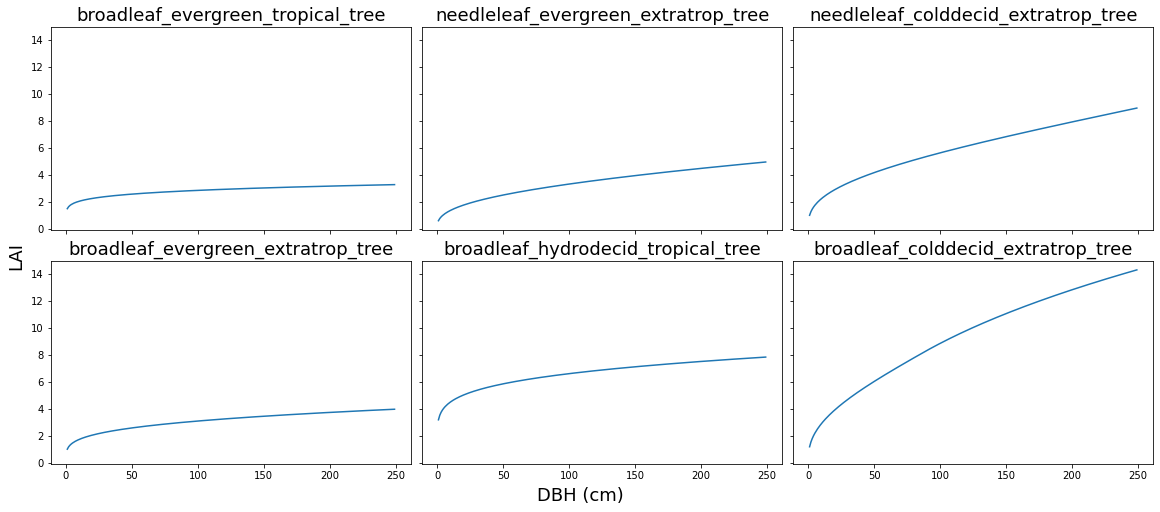

In [88]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 6) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    bleaf_curve = [d2bleaf(d, d2bl1[pf], d2bl2[pf])  for  d  in dbh]
    
    # calculate crown area
    ca_curve = [d2ca(d, ca_p1[pf],  ca_p2[pf])  for  d  in dbh]
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(bleaf_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=18)

fig2.supylabel('LAI', fontsize=18)
fig2.supxlabel('DBH (cm)', fontsize=18)  
;

### Leaf biomass
Note we  abandonded  the following  analysis

In [89]:
# we use the crown area exponent and only estimate  the p1  parameter

In [90]:
initial_guess = [0.07, 1.3]

def d2blmax_def (d, p1, p2) :
    
    bleaf = ( p1 * d ** p2 ) / 2.0
    
    return bleaf

In [91]:
CA_exponents = [ca_ps_bltr[1], ca_ps_nleex[1], ca_ps_nldex[1], ca_ps_bleex[1], ca_ps_bltr[1], ca_ps_bldex[1]]
print(CA_exponents)

[1.4819679358399913, 1.1834372689367554, 0.9851237072592065, 1.7421396694111722, 1.4819679358399913, 1.0498938812892875]


[0.15219511]


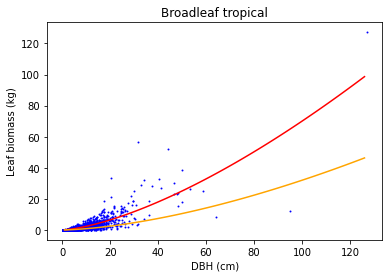

In [92]:
# Broadleaf tropical 
bltr = df_baad[df_baad.PFT_baad=='broadleaf_tropical']
bltr =  bltr.dropna(subset=['bleaf', 'dbh'])
dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

initial_guess = [0.07]

def d2blmax (d, p1) :
    # set the fixed parameter 
    p2 = CA_exponents[0]
    bleaf = ( p1 * d ** p2 ) / 2.0
    return bleaf

bleaf_ps_bltr, bleaf_cov_bltr = curve_fit(f=d2blmax, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['bleaf']),
                                           p0=initial_guess)

bltr_curve = [d2blmax(d, bleaf_ps_bltr[0])  for  d  in dbh_bltr]
bltr_curve2 = [d2blmax_def(d, d2bl1[0], d2bl2[0]) for d in dbh_bltr]

plt.scatter(bltr.dbh, bltr.bleaf, s=0.9, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.plot(dbh_bltr, bltr_curve2, color='orange')
plt.xlabel('DBH (cm)')
plt.ylabel('Leaf biomass (kg)')
plt.title('Broadleaf tropical')

print(bleaf_ps_bltr)

[0.59712498]


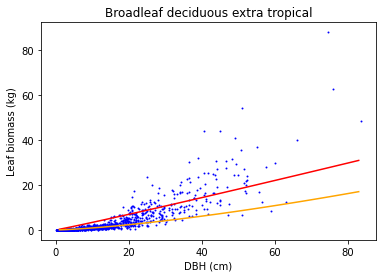

In [93]:
# Broadleaf deciduous extra tropical 
bldex = df_baad[df_baad.PFT_baad=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['bleaf', 'dbh'])
dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

initial_guess = [0.07]

def d2blmax (d, p1) :
    # set the fixed parameter 
    p2 = CA_exponents[5]
    bleaf = ( p1 * d ** p2 ) / 2.0
    return bleaf

bleaf_ps_bldex, bleaf_cov_bldex = curve_fit(f=d2blmax, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['bleaf']),
                                           p0=initial_guess)
bldex_curve = [d2blmax(d, bleaf_ps_bldex[0])  for  d  in dbh_bldex]

bldex_curve2 = [d2blmax_def(d, d2bl1[5], d2bl2[5]) for d in dbh_bldex]


plt.scatter(bldex.dbh, bldex.bleaf, s=0.9, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.plot(dbh_bldex, bldex_curve2, color='orange')
plt.xlabel('DBH (cm)')
plt.ylabel('Leaf biomass (kg)')
plt.title('Broadleaf deciduous extra tropical')

print(bleaf_ps_bldex)

[0.03089973]


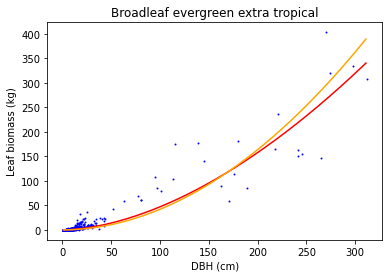

In [94]:
# Broadleaf evergreen extra tropical 
bleex = df_baad[df_baad.PFT_baad=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['bleaf', 'dbh'])
dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

initial_guess = [0.07]

def d2blmax (d, p1) :
    # set the fixed parameter 
    p2 = CA_exponents[3]
    bleaf = ( p1 * d ** p2 ) / 2.0
    return bleaf

bleaf_ps_bleex, bleaf_cov_bleex = curve_fit(f=d2blmax, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['bleaf']),
                                           p0=initial_guess)
bleex_curve = [d2blmax(d, bleaf_ps_bleex[0])  for  d  in dbh_bleex]

bleex_curve2 = [d2blmax_def(d, d2bl1[3], d2bl2[3]) for d in dbh_bleex]


plt.scatter(bleex.dbh, bleex.bleaf, s=0.9, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.plot(dbh_bleex, bleex_curve2, color='orange')
plt.xlabel('DBH (cm)')
plt.ylabel('Leaf biomass (kg)')
plt.title('Broadleaf evergreen extra tropical')

print(bleaf_ps_bleex)

[0.89043719]


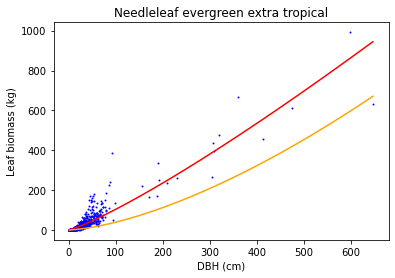

In [95]:
# Needleleaf evergreen extra tropical 
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['bleaf', 'dbh'])
dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

initial_guess = [0.07]

def d2blmax (d, p1) :
    # set the fixed parameter 
    p2 = CA_exponents[1]
    bleaf = ( p1 * d ** p2 ) / 2.0
    return bleaf

bleaf_ps_nleex, bleaf_cov_nleex = curve_fit(f=d2blmax, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['bleaf']),
                                           p0=initial_guess)
nleex_curve = [d2blmax(d, bleaf_ps_nleex[0])  for  d  in dbh_nleex]

nleex_curve2 = [d2blmax_def(d, d2bl1[1], d2bl2[1]) for d in dbh_nleex]


plt.scatter(nleex.dbh, nleex.bleaf, s=0.9, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.plot(dbh_nleex, nleex_curve2, color='orange')
plt.xlabel('DBH (cm)')
plt.ylabel('Leaf biomass (kg)')
plt.title('Needleleaf evergreen extra tropical')

print(bleaf_ps_nleex)

[0.48096926]


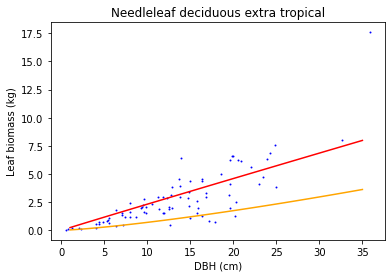

In [96]:
# Needleleaf deciduous extra tropical 
nldex = df_baad[df_baad.PFT_baad=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['bleaf', 'dbh'])
dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

initial_guess = [0.07]

def d2blmax (d, p1) :
    # set the fixed parameter 
    p2 = CA_exponents[2]
    bleaf = ( p1 * d ** p2 ) / 2.0
    return bleaf

bleaf_ps_nldex, bleaf_cov_nldex = curve_fit(f=d2blmax, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['bleaf']),
                                           p0=initial_guess)
nldex_curve = [d2blmax(d, bleaf_ps_nldex[0])  for  d  in dbh_nldex]
nldex_curve2 = [d2blmax_def(d, d2bl1[2], d2bl2[2]) for d in dbh_nldex]


plt.scatter(nldex.dbh, nldex.bleaf, s=0.9, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.plot(dbh_nldex, nldex_curve2, color='orange')
plt.xlabel('DBH (cm)')
plt.ylabel('Leaf biomass (kg)')
plt.title('Needleleaf deciduous extra tropical')

print(bleaf_ps_nldex)

''

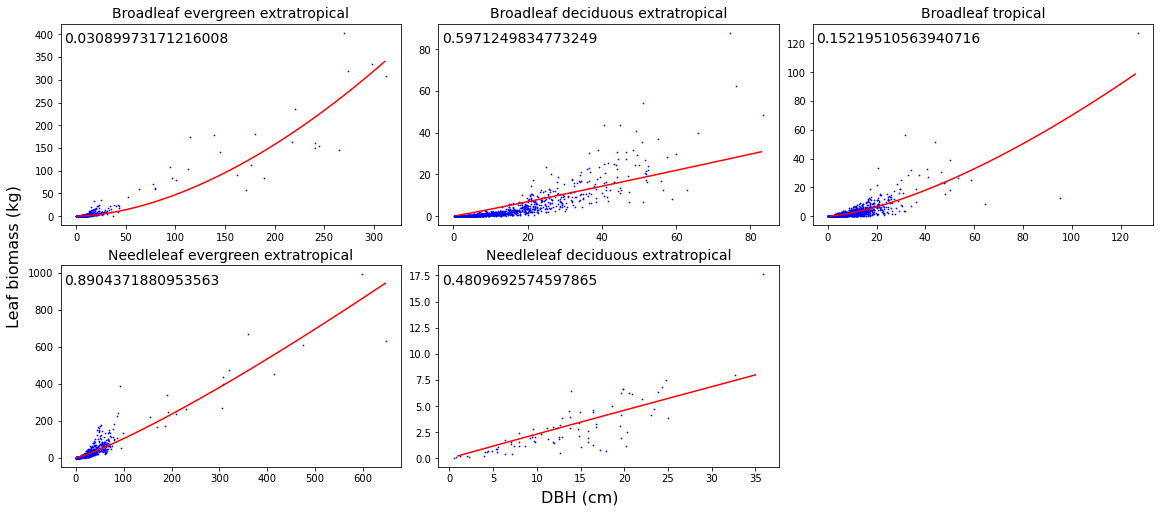

In [97]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.bleaf, s=0.5, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)
f2ax3.text(.01, .96, bleaf_ps_nleex[0], ha='left', va='top', transform=f2ax3.transAxes, fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.bleaf, s=0.5, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)
f2ax4.text(.01, .96, bleaf_ps_nldex[0], ha='left', va='top', transform=f2ax4.transAxes, fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.bleaf, s=0.5, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)
f2ax0.text(.01, .96, bleaf_ps_bleex[0], ha='left', va='top', transform=f2ax0.transAxes, fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.bleaf, s=0.5, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)
f2ax1.text(.01, .96, bleaf_ps_bldex[0], ha='left', va='top', transform=f2ax1.transAxes, fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.bleaf, s=0.5, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)
f2ax2.text(.01, .96, bleaf_ps_bltr[0], ha='left', va='top', transform=f2ax2.transAxes, fontsize=14)


f2ax5.axis('off')

fig2.supylabel('Leaf biomass (kg)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;